# Plant Pathology

In [1]:
from fastai.vision.all import *
%config Completer.use_jedi = False

In [2]:
# Hyperparameters
valid_pct = 0.2

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/')
path.ls()

(#5) [Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/test_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/plant-pathology-2021-fgvc8.zip'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train.csv')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'train_images').ls()

(#18632) [Path('train_images/d7707b87601e9721.jpg'),Path('train_images/f1c0918f0b1ff4d8.jpg'),Path('train_images/9fd08acafc84e664.jpg'),Path('train_images/d4eccc89612723b7.jpg'),Path('train_images/bc287d94706dd853.jpg'),Path('train_images/90fc3c90d72f05f4.jpg'),Path('train_images/b5d7d2cdcf0d0c04.jpg'),Path('train_images/e07485de9fbca409.jpg'),Path('train_images/a7b91490d7de5a82.jpg'),Path('train_images/dce254af368e2658.jpg')...]

In [6]:
(path/'test_images').ls()

(#3) [Path('test_images/c7b03e718489f3ca.jpg'),Path('test_images/85f8cb619c66b863.jpg'),Path('test_images/ad8770db05586b59.jpg')]

The labels of the training images are in `train.csv` which has a space delimited list of labels for each image.

In [7]:
df = pd.read_csv(path/'train.csv')
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [8]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(540, min_scale=0.35)
)

# dsets = dblock.datasets(df)
# dsets.train[0]
dls = dblock.dataloaders(df)

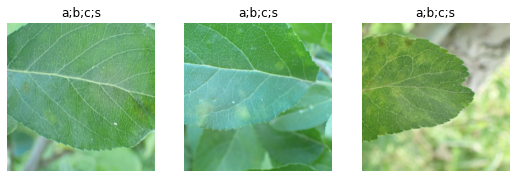

In [9]:
dls.show_batch(nrows=1, ncols=3)

In [10]:
learn = cnn_learner(dls, arch=resnet18)

/media/xar/barracuda1/fast.ai/conda-lab3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
x,y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 22])

In [12]:
activations[0]

tensor([-0.5822, -3.5359,  1.8631,  1.9812, -0.5394,  0.7026, -2.1917, -0.2511,
         2.1642, -1.0345,  0.6531,  0.2678,  1.9351, -1.9545,  0.6629,  1.5753,
        -3.6166,  0.2370,  1.5819,  1.6464, -0.9750, -2.0992],
       grad_fn=<SelectBackward>)

In [13]:
loss_func = nn.BCEWithLogitsLoss()
loss_func(activations, y)

TensorMultiCategory(1.0615, grad_fn=<AliasBackward>)

In [14]:
# def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
#     """ Compute accuracy when input and target are the same size
#     """
#     if sigmoid: inp.sigmoid()
#     return ((inp>thresh)==targ.bool()).float().mean()

In [15]:
# learn = cnn_learner(dls,
#                     arch=resnet18,
#                     loss_func=loss_func,
#                     metrics=partial(accuracy_multi,
#                                     thresh=0.5)
#                    )
# learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

In [16]:
learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   )
learn.fine_tune(6, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,0.652947,0.446864,0.661858,11:58
1,0.316656,0.228825,0.798525,12:27
2,0.237947,0.188799,0.825392,12:33
3,0.199197,0.166579,0.862326,12:35


epoch,train_loss,valid_loss,f1_score,time
0,0.165200,0.129630,0.889869,12:38
1,0.147843,0.115992,0.899224,12:41
2,0.126777,0.115416,0.887660,12:42
3,0.106422,0.113750,0.898690,12:40
4,0.090591,0.102554,0.912493,12:42
5,0.070567,0.101672,0.914514,12:38


In [18]:
learn.export('plant_resnet18.pkl')
# learn = load_learner(path/'plant_resnet18.pkl')

In [ ]:
learn.recorder

In [17]:
preds,targs = learn.get_preds()

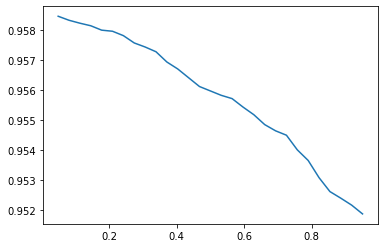

In [18]:
xs = torch.linspace(0.05,0.95,29)
fs = [F1ScoreMulti()]
accs = [F(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);